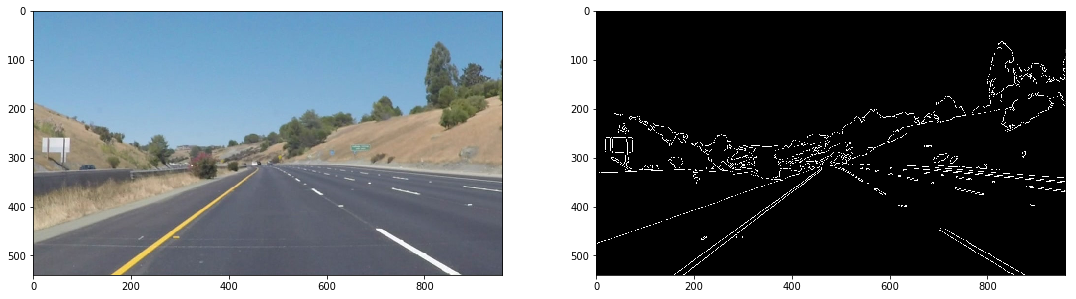

In [14]:
# CANNY EDGE DETECTION

#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import itertools as it

# Read in the image and convert to grayscale
image = mpimg.imread('solidYellowCurve2-Copy1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(edges, cmap='Greys_r')

plt.show()


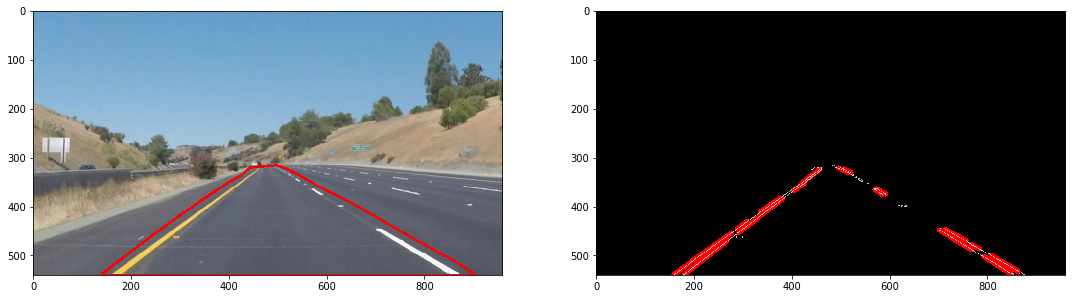

In [15]:
# MASKING AND P-HOUGH TRANSFORM TO GET LINE AND LINE-COORDINATES

# make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing

# obtain these coordinates using WebPlotDigitizer at https://apps.automeris.io/wpd/
mask_cords = [(136.74238606816763, 540),
(207.94952935722498, 484.7318243202386),
(277.8989377784048, 432.72529377380926),
(345.2845020458347, 385.8061395198839),
(396.1340777618769, 351.57317638522153),
(426.6260859049039, 333.83588978695093),
(443.17013685929084, 319.87583899381207),
(497.6316691189809, 314.9537419627919),
(517.8360510350109, 322.66139923004044),
(543.0713724225506, 335.48061999879053),
(577.1269626912301, 354.69735754741686),
(612.4564126337855, 372.644266623667),
(650.3093947150949, 391.8730977767923),
(700.7558502811763, 421.3331183359199),
(780.2108318384295, 467.44603228992383),
(865.9947997500653, 513.5791022514258),
(905.0571422812569, 540)]


mask_cords = np.round(mask_cords)
mask_cords = mask_cords.astype(int)
mask_cords = tuple(map(tuple,mask_cords))

# Draw a line with thickness of 4 px
ic = 1
while (ic<len(mask_cords)):
    region_select = cv2.line(region_select,mask_cords[ic-1],mask_cords[ic],(255,0,0),4)
    ic = ic+1
    
region_select = cv2.line(region_select,mask_cords[-1],mask_cords[0],(255,0,0),4)


# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255

# This time we are defining a n sided polygon to mask
imshape = image.shape
vertices = np.array([mask_cords], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 15
max_line_gap = 1
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
m_parm = []
b_parm = []
x1_parm = []
y1_parm = []
x2_parm = []
y2_parm = []

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        m_parm.append((y2-y1)/(x2-x1))
        b_parm.append(y1-x1*(y2-y1)/(x2-x1))
        x1_parm.append(x1)
        y1_parm.append(y1)
        x2_parm.append(x2)
        y2_parm.append(y2)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(region_select, cmap='Greys_r')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(combo)

plt.show()


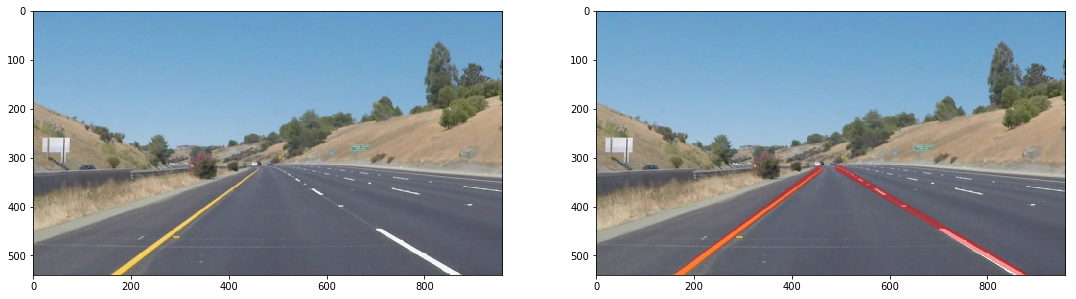

In [16]:
# DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
# USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
# ONCE SORTED 
# DETERMINE 
# > AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
# > MIN Y FOR EACH OF LEFT AND RIGHT LANES AND CORRESPONDING X
# > using MEAN SLOPES AND and MIN Ys and CORRESPONDING Xs DETERMINE bs in y=mx+b
# > using MEAN SLOPES AND bs AND Y=540 (X-AXIS LINE) DETERMINE CORRESPONDING X

# Capture all (x,y) coordinates for the masked edge lines
m_parm = np.asarray(m_parm)
b_parm = np.asarray(b_parm)
x1_parm = np.asarray(x1_parm)
y1_parm = np.asarray(y1_parm)
x2_parm = np.asarray(x2_parm)
y2_parm = np.asarray(y2_parm)

mp_sort = sorted(m_parm)
b_sort = b_parm[np.argsort(m_parm)]
x1_sort = x1_parm[np.argsort(m_parm)]
y1_sort = y1_parm[np.argsort(m_parm)]
x2_sort = x2_parm[np.argsort(m_parm)]
y2_sort = y2_parm[np.argsort(m_parm)]

mp_neg = list(filter(lambda x: x < 0, m_parm)) 
mp_neg_len = len(mp_neg)
mp_neg_m = mp_sort[0:mp_neg_len]
mp_neg_b = b_sort[0:mp_neg_len]
mp_neg_x1 = x1_sort[0:mp_neg_len]
mp_neg_y1 = y1_sort[0:mp_neg_len]
mp_neg_x2 = x2_sort[0:mp_neg_len]
mp_neg_y2 = y2_sort[0:mp_neg_len]

mp_neg_x = np.hstack((mp_neg_x1,mp_neg_x2))
mp_neg_y = np.hstack((mp_neg_y1,mp_neg_y2))

min_neg_y = np.min(mp_neg_y)
min_neg_yx = mp_neg_x[np.argmin(mp_neg_y)]

lmn_x1y1 = (min_neg_yx,min_neg_y)

mmp_neg = np.mean(mp_neg)
bp_neg = min_neg_y-mmp_neg*min_neg_yx
lmn_x2 = int(round((ysize-bp_neg)/mmp_neg))
lmn_x2y2 = (lmn_x2,ysize)

mp_pos = list(filter(lambda x: x > 0, m_parm))
mp_pos_m = mp_sort[(mp_neg_len):]
mp_pos_b = b_sort[(mp_neg_len):]
mp_pos_x1 = x1_sort[(mp_neg_len):]
mp_pos_y1 = y1_sort[(mp_neg_len):]
mp_pos_x2 = x2_sort[(mp_neg_len):]
mp_pos_y2 = y2_sort[(mp_neg_len):]

mp_pos_x = np.hstack((mp_pos_x1,mp_pos_x2))
mp_pos_y = np.hstack((mp_pos_y1,mp_pos_y2))

min_pos_y = np.min(mp_pos_y)
min_pos_yx = mp_pos_x[np.argmin(mp_pos_y)]
lmp_x1y1 = (min_pos_yx,min_pos_y)

mmp_pos = np.mean(mp_pos)
bp_pos = min_pos_y-mmp_pos*min_pos_yx
lmp_x2 = int(round((ysize-bp_pos)/mmp_pos))
lmp_x2y2 = (lmp_x2,ysize)


lane_select = np.copy(image)
lane_select2 = np.copy(image)
# Draw a line with thickness of 4 px
lane_select = cv2.line(lane_select,lmn_x1y1,lmn_x2y2,(255,0,0),14)
lane_select = cv2.line(lane_select,lmp_x1y1,lmp_x2y2,(255,0,0),14)

alpha = 0.4  # Transparency factor.
lane_select = cv2.addWeighted(lane_select, alpha, image, 1 - alpha, 0)


# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(lane_select)

plt.show()

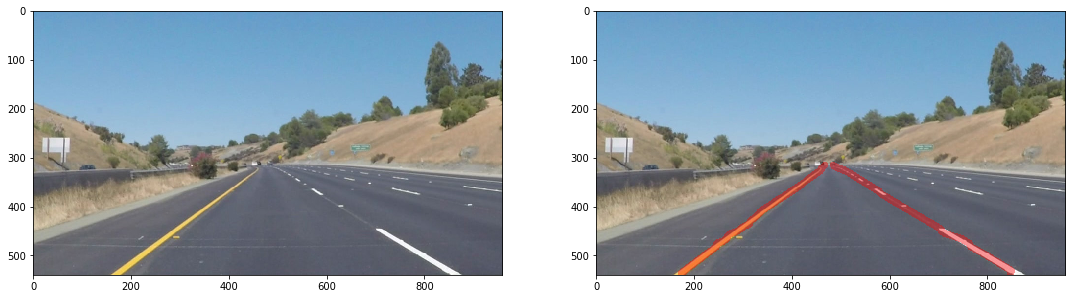

In [19]:
# DETERMINE SLOPE OF ALL THE LINES WITHIN THE MASK
# USE SLOPE>0 AND SLOPE<0 TO SORT LEFT AND RIGHT LANES
# ONCE SORTED 
# DETERMINE 
# > INSTEAD OF AVERAGE/MEAN SLOPES FOR EACH OF LEFT AND RIGHT LANES
# > CREATE SEVRAL BINS, WHERE EACH BIN CORESPONDS TO DIFFERENT RANGE OF SLOPE/SLOPES
# > REPEAT THE BIN CREATION FOR EACH OF LEFT AND RIGHT LANES

# > 
# > 
# > 

mp_neg_2m = np.hstack((mp_neg_m,mp_neg_m))
mp_neg_2b = np.hstack((mp_neg_b,mp_neg_b))

min_neg_y = np.min(mp_neg_y)
max_neg_y = np.max(mp_neg_y)

mp_neg_y_so = sorted(mp_neg_y)
mp_neg_2m_so = mp_neg_2m[np.argsort(mp_neg_y)]
mp_neg_2b_so = mp_neg_2b[np.argsort(mp_neg_y)]

mp_pos_2m = np.hstack((mp_pos_m,mp_pos_m))
mp_pos_2b = np.hstack((mp_pos_b,mp_pos_b))

min_pos_y = np.min(mp_pos_y)
max_pos_y = np.max(mp_pos_y)

mp_pos_y_so = sorted(mp_pos_y)
mp_pos_2m_so = mp_pos_2m[np.argsort(mp_pos_y)]
mp_pos_2b_so = mp_pos_2b[np.argsort(mp_pos_y)]

# create y-vector
min_y = np.min([min_neg_y, min_pos_y])
min_ym5 = min_y - min_y%5
yg_vec = np.arange(min_ym5,ysize,5)
yg_vec = sorted(yg_vec, reverse=True)
yg_vec = np.append(yg_vec,[min_ym5-5])
# yg_vec = np.append(yg_vec,[min_ym5-5, min_ym5-10])

# -ve slope
# lower bound
y_clb = yg_vec[0]
if (y_clb>max_neg_y):
    mn_clb = mp_neg_2m[np.argmax(mp_neg_y)]
    bn_clb = mp_neg_2b[np.argmax(mp_neg_y)]
    xn_clb = (y_clb-bn_clb)/mn_clb
elif (y_clb<min_neg_y):
    mn_clb = mp_neg_2m[np.argmin(mp_neg_y)]
    bn_clb = mp_neg_2b[np.argmin(mp_neg_y)]
    xn_clb = (y_clb-bn_clb)/mn_clb    
else:
    tv1 = np.searchsorted(mp_neg_y_so, y_clb)
    if ((tv1+1)==len(mp_neg_y_so)):
        mn_clb = mp_neg_2m_so[tv1]
        bn_clb = mp_neg_2b_so[tv1]
        xn_clb = (y_clb-bn_clb)/mn_clb        
    else:
        mn_clb = np.mean([mp_neg_2m_so[tv1], mp_neg_2m_so[tv1+1]])
        bn_clb = np.mean([mp_neg_2b_so[tv1], mp_neg_2b_so[tv1+1]])
        xn_clb = (y_clb-bn_clb)/mn_clb

xyn_lb = (int(round(xn_clb)),y_clb)    

# +ve slope
# lower bound
if (y_clb>max_pos_y):
    mp_clb = mp_pos_2m[np.argmax(mp_pos_y)]
    bp_clb = mp_pos_2b[np.argmax(mp_pos_y)]
    xp_clb = (y_clb-bp_clb)/mp_clb
elif (y_clb<min_pos_y):
    mp_clb = mp_pos_2m[np.argmin(mp_pos_y)]
    bp_clb = mp_pos_2b[np.argmin(mp_pos_y)]
    xp_clb = (y_clb-bp_clb)/mp_clb    
else:
    tv2 = np.searchsorted(mp_pos_y_so, y_clb)
    if ((tv2+1)==len(mp_pos_y_so)):
        mp_clb = mp_pos_2m_so[tv2]
        bp_clb = mp_pos_2b_so[tv2]
        xp_clb = (y_clb-bp_clb)/mp_clb
    else:
        mp_clb = np.mean([mp_pos_2m_so[tv2], mp_pos_2m_so[tv2+1]])
        bp_clb = np.mean([mp_pos_2b_so[tv2], mp_pos_2b_so[tv2+1]])
        xp_clb = (y_clb-bp_clb)/mp_clb

xyp_lb = (int(round(xp_clb)),y_clb)

ic = 1
while (ic<len(yg_vec)):
    # upper bound
    y_cub = yg_vec[ic]

    # -ve slope
    if (y_cub>max_neg_y):
        mn_cub = mp_neg_2m[np.argmax(mp_neg_y)]
        bn_cub = mp_neg_2b[np.argmax(mp_neg_y)]
        xn_cub = (y_cub-bn_cub)/mn_cub
    elif (y_cub<min_neg_y):
        mn_cub = mp_neg_2m[np.argmin(mp_neg_y)]
        bn_cub = mp_neg_2b[np.argmin(mp_neg_y)]
        xn_cub = (y_cub-bn_cub)/mn_cub
    else:        
        tv1 = np.searchsorted(mp_neg_y_so, y_cub)
        if ((tv1+1)==len(mp_neg_y_so)):
            mn_cub = mp_neg_2m_so[tv1]
            bn_cub = mp_neg_2b_so[tv1]
            xn_cub = (y_cub-bn_cub)/mn_cub
        else:
            mn_cub = np.mean([mp_neg_2m_so[tv1], mp_neg_2m_so[tv1+1]])
            bn_cub = np.mean([mp_neg_2b_so[tv1], mp_neg_2b_so[tv1+1]])
            xn_cub = (y_cub-bn_cub)/mn_cub

    xyn_ub = (int(round(xn_cub)),y_cub)

    # +ve slope
    if (y_cub>max_pos_y):
        mp_cub = mp_pos_2m[np.argmax(mp_pos_y)]
        bp_cub = mp_pos_2b[np.argmax(mp_pos_y)]
        xp_cub = (y_cub-bp_cub)/mp_cub
    elif (y_cub<min_pos_y):
        mp_cub = mp_pos_2m[np.argmin(mp_pos_y)]
        bp_cub = mp_pos_2b[np.argmin(mp_pos_y)]
        xp_cub = (y_cub-bp_cub)/mp_cub    
    else:
        tv2 = np.searchsorted(mp_pos_y_so, y_cub)
        if ((tv2+1)==len(mp_pos_y_so)):
            mp_cub = mp_pos_2m_so[tv2]
            bp_cub = mp_pos_2b_so[tv2]
            xp_cub = (y_cub-bp_cub)/mp_cub
        else:
            mp_cub = np.mean([mp_pos_2m_so[tv2], mp_pos_2m_so[tv2+1]])
            bp_cub = np.mean([mp_pos_2b_so[tv2], mp_pos_2b_so[tv2+1]])
            xp_cub = (y_cub-bp_cub)/mp_cub

    xyp_ub = (int(round(xp_cub)),y_cub)
    
    # Draw a line with thickness of 4 px
    lane_select2 = cv2.line(lane_select2,xyn_lb,xyn_ub,(255,0,0),14)
    lane_select2 = cv2.line(lane_select2,xyp_lb,xyp_ub,(255,0,0),14)    
    
    xyn_lb = xyn_ub
    xyp_lb = xyp_ub
    
    ic = ic+1

alpha = 0.4  # Transparency factor.
lane_select2 = cv2.addWeighted(lane_select2, alpha, image, 1 - alpha, 0)
    
# Display the image
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(lane_select2)

plt.show()    